In [20]:
import argparse
# import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
# import sklearn
from ast import literal_eval

import warnings
warnings.filterwarnings("ignore")

In [21]:
#from src.tmdb_frame import tmdb_frame
from src.tmdb_model import tmdb_model
from src.tmdb_linreg import tmdb_linreg

In [22]:
data = pd.read_csv('../02_Data/2B_data-output_10.27.1700.csv', index_col=0)

In [23]:
data.head(6)

,opening_revenue,budget,runtime,position_in_series,previous_film_release,previous_film_rating,cast_xp_median,cast_rating_max,writer_xp_median,writer_xp_sum,...,is_may,is_jun,is_jul,is_aug,is_sep,is_oct,is_nov,is_dec,first_time_writers,first_time_directors
id,,,,,,,,,,,,,,,,,,,,,
59,364000.0,32000000.0,96.0,1,0.0,0.0,43.0,8.500,3.5,7.0,...,0,0,0,0,1,0,0,0,0,0
8976,7576593.0,30000000.0,107.0,1,0.0,0.0,12.0,7.574,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
10077,917398.0,80000000.0,101.0,1,0.0,0.0,21.0,10.000,6.0,62.0,...,1,0,0,0,0,0,0,0,0,0
8202,12661112.0,62000000.0,93.0,1,0.0,0.0,23.0,10.000,4.0,17.0,...,0,0,0,0,0,0,1,0,0,0
22559,479368.0,26000000.0,95.0,1,0.0,0.0,2.0,8.400,7.0,7.0,...,0,0,0,0,0,0,0,0,0,0
12142,2834421.0,20000000.0,98.0,1,0.0,0.0,21.0,10.000,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0


                             OLS Regression Results                             
Dep. Variable:     sqrt_opening_revenue   R-squared:                       0.648
Model:                              OLS   Adj. R-squared:                  0.630
Method:                   Least Squares   F-statistic:                     35.73
Date:                  Mon, 28 Oct 2024   Prob (F-statistic):           1.82e-93
Time:                          21:33:55   Log-Likelihood:                -4366.0
No. Observations:                   511   AIC:                             8784.
Df Residuals:                       485   BIC:                             8894.
Df Model:                            25                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons

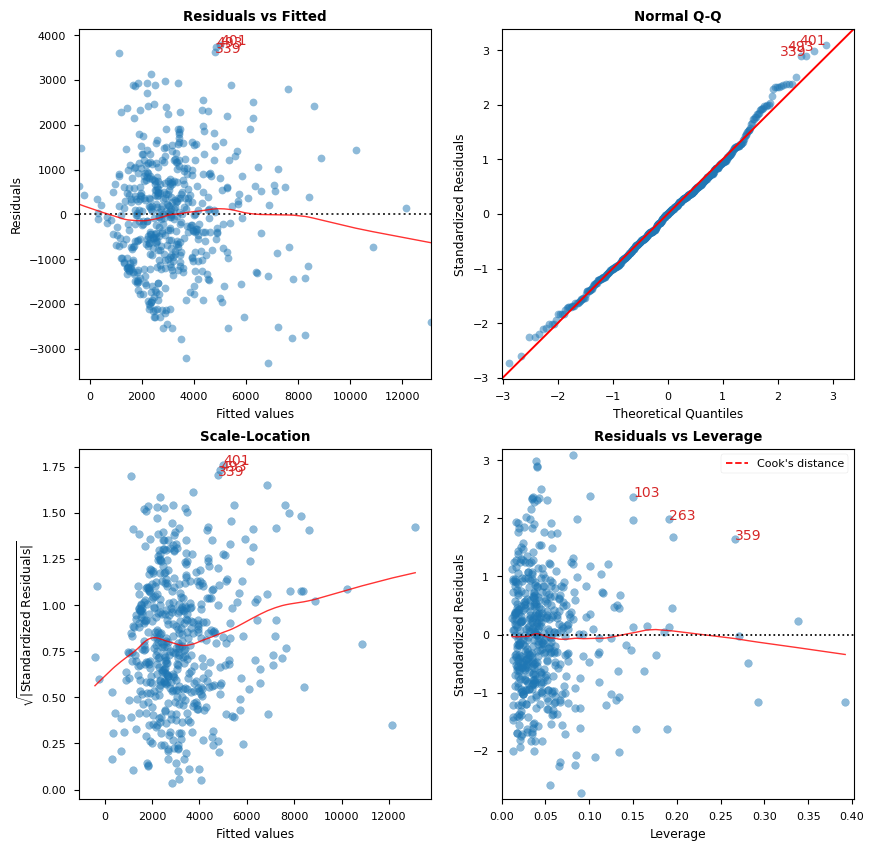

In [24]:
# Initialize TMDB model class.
mdl = tmdb_model()

cdf = data

# Generate pair plot of continuous covariates.
#sns.pairplot(cdf[['opening_revenue', 'budget', 'num_production_companies', 'runtime', 'month', 'pct_indie']])

# Generate transformed covariates.
cov_transform = {'opening_revenue': 'sqrt'}

# Generate joint covariates.
month_id = ['is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun', \
            'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec']
genre_id = ['is_adventure', 'is_fantasy', 'is_animation', 'is_drama', 'is_horror', 'is_action', \
            'is_comedy', 'is_history', 'is_thriller', 'is_crime', 'is_documentary', 'is_sci_fi', \
            'is_mystery', 'is_music', 'is_romance', 'is_family']
season_id = ['is_winter', 'is_spring', 'is_summer', 'is_fall']

joint_id = []

for i in range(len(month_id)):

    for j in range(len(genre_id)):

        cdf[str(month_id[i] + '_*_' + genre_id[j])] = (cdf[month_id[i]] * cdf[genre_id[j]]) # Month-genre interaction
        joint_id.append(str(month_id[i] + '_*_' + genre_id[j]))

for i in range(len(genre_id)):

    for j in range((i+1), len(genre_id)):

        cdf[str(genre_id[i] + '_*_' + genre_id[j])] = (cdf[genre_id[i]] * cdf[genre_id[j]]) # Month-month interaction
        joint_id.append(str(genre_id[i] + '_*_' + genre_id[j]))

cdf['is_series_*_is_sci_fi'] = (cdf['is_series'] * cdf['is_sci_fi'])                        # Series-genre interaction

# Generate OLS model.
model_cut = ['budget', 'num_production_companies', 'crew', 'cast_xp_median', 'is_series', 'previous_film_release', 'previous_film_rating', 'first_time_directors', \
            'is_feb', 'is_mar', 'is_sep', 'is_oct', 'is_dec', \
            'is_horror', 'is_romance', 'is_comedy', 'is_family', 'is_animation', 'is_sci_fi', 'is_drama', \
            'is_oct_*_is_horror', 'is_dec_*_is_family', \
            'is_comedy_*_is_romance', 'is_animation_*_is_family', \
            'is_series_*_is_sci_fi']

Y = ['opening_revenue']
X = model_cut

_, res = mdl.get_ols_model(cdf, Y, X, cov_transform=cov_transform)

# Generate linear regression diagnostics for OLS model.
print(res.summary())

diag = tmdb_linreg(res)
vif, fig, ax = diag()